## CNN inference example in Pytorch

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import pycomlink as pycml
from pycomlink.processing.pytorch_utils import run_inference

C:\Users\lukas\Documents\OpenSense\pycomlink\pycomlink\io\examples.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [3]:
# Dataarray shape is expected to be (time, channels, cml_id)
tl = cmls.tl.transpose('time', 'channel_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

# Standardization should be part of the specific model, because it is trained with specific preprocessing

### Option 1: Load DL model from local .pt file


In [ ]:
# Set up your own path:
weights_path = 'C:/Users/lukas/.cml_wd_pytorch/models/best_model_jit.pt'
result = run_inference.cnn_wd(model_path_or_url=weights_path, data=tl_normed)

### Option 2: Load the model from URL and cahe it

In [4]:
# Url adress:
model_URL = "https://github.com/jpolz/cml_wd_pytorch/raw/be2b15fa987838ea1f709dd0180917eebf66271a/data/dummy_model/best_model_jit.pt"
result = run_inference.cnn_wd(model_path_or_url=model_URL,data=tl_normed)

Using cached model at C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt
✅ Loaded exported model from: C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt


### Output plots

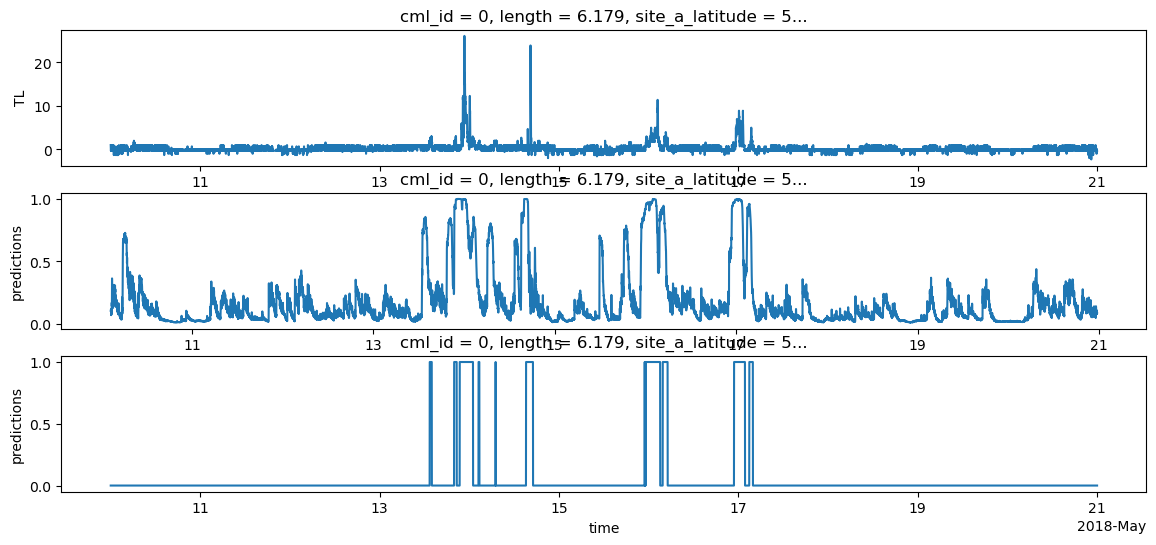

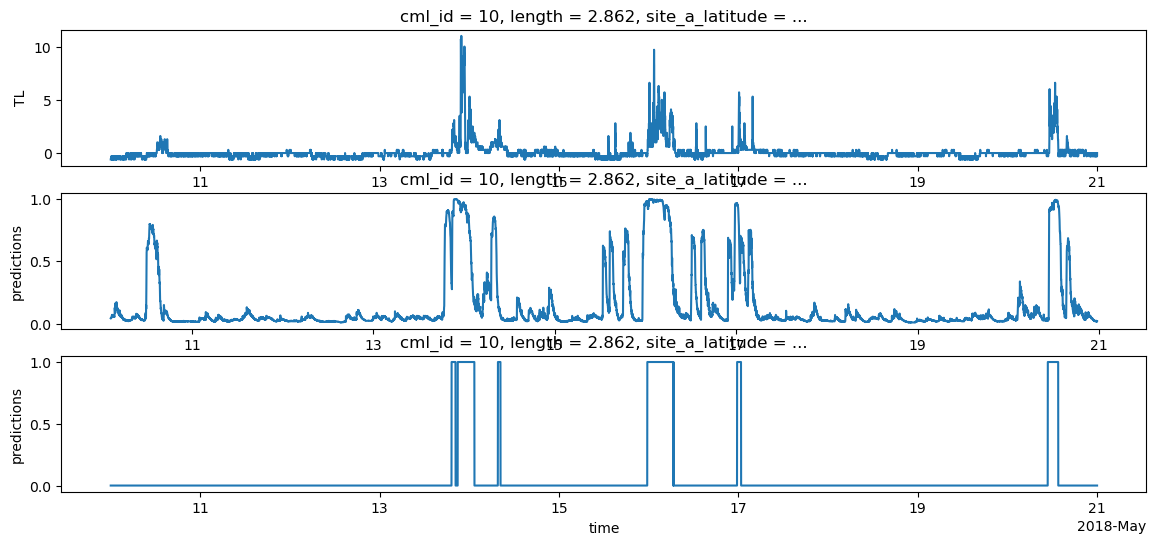

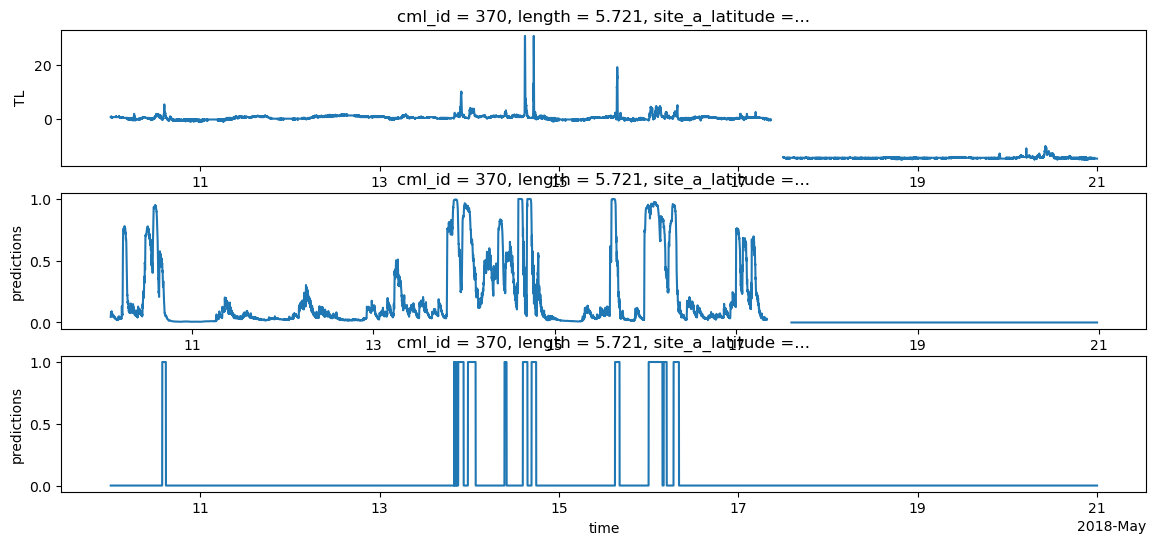

In [5]:
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(3, 1, figsize=(14, 6))
    result.TL.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    result.predictions.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    (result.predictions.sel(cml_id=cml_id)>0.8).plot.line(x='time', ax=axs[2])
    
